In [21]:
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings("ignore")

p = matplotlib.rcParams
p["font.family"] = "Times New Roman" #"sans-serif"
# p["font.sans-serif"] = ["SimHei", "Tahoma"]
p["font.size"] = 20
p["axes.unicode_minus"] = False
p['lines.linewidth'] = 2
p['pdf.fonttype'] = 42
p['ps.fonttype'] = 42

# read the data from db

In [ ]:
import sqlite3 as sql
conn = sql.connect(r".\sqf.db")
c = conn.cursor()

query = "select * from cleanedsqf_1416"

dataRaw = pd.read_sql(query, conn)
conn.commit()
conn.close()

dataRaw = dataRaw.set_index('id')

In [ ]:
cols = list(dataRaw.columns)
cols[cols.index('datestop')] = 'month'
dataRaw.columns = cols

## add cpi and market index data

In [ ]:
cpi = pd.read_excel(r"C:\Users\binxi\Desktop\MFE 19-20\courses\ORIE 4741\project\USCPI.xls", index_col=0, date_parser=False)
cpi = cpi.iloc[:, [0, 4, 5, 6, 7, 8]]
cpi_cols = ['CPI', 'CPI_F', 'CPI_H', 'CPI_C', 'CPI_T', 'CPI_M']
cpi.columns = cpi_cols

In [ ]:
# shift to use available data
cpi = cpi.shift(1).dropna()
idx = [str(i)[:7] for i in list(cpi.index)]
cpi.index = idx
cpi.head()

In [ ]:
dataRaw['ym'] = dataRaw['year'].apply(lambda x: str(x) + '-') + dataRaw['month'].apply(lambda x: str(x).rjust(2, '0'))
dataRaw = dataRaw.set_index('ym')
dataRaw = dataRaw.join(cpi, how='left')
dataRaw.head()

In [ ]:
sp = pd.read_excel(r"C:\Users\binxi\Desktop\MFE 19-20\courses\ORIE 4741\project\SP500.xlsx", index_col=0, date_parser=False)
sp = sp.iloc[:, [3]]
sp.columns = ['SP500']
sp = sp.resample('M').mean()
idx = [str(i)[:7] for i in list(sp.index)]
sp.index = idx
sp.head()

In [ ]:
dataRaw = dataRaw.join(sp, how='left')
dataRaw.head()

## observe missing data

In [ ]:
dataRaw = dataRaw.replace(' ', np.nan)
dataRaw = dataRaw.replace('**', np.nan)
nullOb = dataRaw.isnull().sum()
nullOb[nullOb != 0]

In [ ]:
dataRaw = dataRaw.dropna()
print (np.shape(dataRaw))

## drop samples with useless info

In [ ]:
dataRaw = dataRaw.loc[(dataRaw['haircolr'] != 'XX') & (dataRaw['eyecolor'] != 'XX')]
dataRaw = dataRaw.loc[(dataRaw['sex'] != 'Z') & (dataRaw['build'] != 'Z')]
dataRaw = dataRaw.loc[dataRaw['race'] != 'U']
print (np.shape(dataRaw))
print (dataRaw['arstmade'].value_counts())
print (dataRaw['sex'].value_counts())
print (dataRaw['race'].value_counts())
print (dataRaw['haircolr'].value_counts())
print (dataRaw['eyecolor'].value_counts())
print (dataRaw['build'].value_counts())

## check feature data type and distribution

In [ ]:
[print (i, j, end='\t\t') for i, j in dataRaw.dtypes.iteritems()]
for col in cols[cols.index('radio'):cols.index('perstop')+1]:
    dataRaw.loc[:, col] = dataRaw.loc[:, col].astype('int64')
dataRaw.describe()
# information except sex, haircolor, eyecolor, build, race

In [ ]:
dataRaw = dataRaw.drop('machgun', 1)

# drop outliers

In [ ]:
def filterOutPercentile(dataRaw, col, perc):
    LB = np.percentile(dataRaw[col], perc)
    UB = np.percentile(dataRaw[col], 100-perc)
    dataRaw = dataRaw[(dataRaw[col] >= LB) & (dataRaw[col] < UB)]
    print (np.shape(dataRaw))
    return dataRaw

dataRaw = filterOutPercentile(dataRaw, 'age', .3)
dataRaw = filterOutPercentile(dataRaw, 'ht', .5)
dataRaw = filterOutPercentile(dataRaw, 'weight', .5)
dataRaw.describe()

In [ ]:
dataClean = dataRaw.copy()

# read cleaned data directly!

In [24]:
#dataClean.to_csv(r".\DC.csv")
dataClean = pd.read_csv(r".\DC.csv", index_col=0)
[print (i, j, end='\t\t') for i, j in dataClean.dtypes.iteritems()];

arstmade int64		timestop int64		inout int64		crimsusp int64		offunif int64		frisked int64		searched int64		contrabn int64		pistol int64		riflshot int64		asltweap int64		knifcuti int64		othrweap int64		addrpct int64		sex object		race object		age float64		weight float64		haircolr object		eyecolor object		build object		ht float64		year int64		month int64		radio int64		ac_rept int64		ac_inves int64		rf_vcrim int64		rf_othsw int64		ac_proxm int64		rf_attir int64		cs_objcs int64		cs_descr int64		cs_casng int64		cs_lkout int64		rf_vcact int64		cs_cloth int64		cs_drgtr int64		ac_evasv int64		ac_assoc int64		cs_furtv int64		rf_rfcmp int64		ac_cgdir int64		rf_verbl int64		cs_vcrim int64		cs_bulge int64		cs_other int64		ac_incid int64		ac_time int64		rf_knowl int64		ac_stsnd int64		ac_other int64		sb_hdobj int64		sb_outln int64		sb_admis int64		sb_other int64		explnstp int64		othpers int64		sumissue int64		perobs int64		perstop int64		typeofid object		CPI float64		CPI_F float64		CPI_H float64		CP

# feature heat map

In [12]:
import scipy.stats as stats

cols_all = set(dataClean.columns)

cats = ['crimsusp',
        'addrpct', 'sex', 'race',
        'haircolr', 'eyecolor', 'build',
        'typeofid']
cats = set(cats)

conts = cols_all - cats

def getGenCorr(a, b):
    if a == b:
        return 1
    if (a in conts and b in conts):
        return dataClean.loc[:, [a, b]].corr().iloc[0, 1]
    data = dataClean.loc[:, [a, b]].groupby([a, b]).size().reset_index()
    #print (data)
    data = data.pivot_table(index=a, values=0, columns=b).fillna(0)
    #print (data, np.shape(data))
    chi2 = stats.chi2_contingency(data)[0]
    den = min(np.shape(data))-1
    return np.sqrt((chi2/len(dataClean))/den)

In [13]:
corrs = pd.DataFrame(index=cats, columns=cats)
visited = []

for a in cols_all:
    for b in cols_all:
        if (b, a) not in visited:
            corrs.loc[a, b] = getGenCorr(a, b)
        else:
            corrs.loc[a, b] = corrs.loc[b, a]
        visited.append((a, b))   
corrs = corrs.astype('float32')

In [44]:
chosen_fhm = abs(corrs['arstmade']).sort_values(ascending=False)[:14].index
chosen_fhm

Index(['arstmade', 'sb_other', 'searched', 'contrabn', 'addrpct', 'crimsusp',
       'inout', 'knifcuti', 'rf_othsw', 'pistol', 'sb_admis', 'othrweap',
       'sb_outln', 'cs_casng'],
      dtype='object')

In [53]:
corr_chosen = corrs[chosen_fhm].loc[chosen_fhm]
corr_chosen

,arstmade,sb_other,searched,contrabn,addrpct,crimsusp,inout,knifcuti,rf_othsw,pistol,sb_admis,othrweap,sb_outln,cs_casng
arstmade,1.000000,0.527290,0.509582,0.377584,0.318247,0.254448,0.247351,0.223633,0.172820,0.154133,0.143137,0.125859,0.112431,-0.107955
sb_other,0.527290,1.000000,0.731838,0.269184,0.199996,0.161593,0.155392,0.076631,0.265022,0.070176,-0.003165,0.064866,-0.000662,-0.086912
searched,0.509582,0.731838,1.000000,0.274575,0.198263,0.140888,0.116884,0.242640,0.235103,0.135679,0.222794,0.133894,0.233993,-0.091698
contrabn,0.377584,0.269184,0.274575,1.000000,0.152516,0.144637,0.065836,0.071717,0.096647,0.089137,0.065123,0.037016,0.040007,-0.046165
addrpct,0.318247,0.199996,0.198263,0.152516,1.000000,0.145123,0.381859,0.170510,0.174244,0.081636,0.078421,0.066762,0.093557,0.289638
crimsusp,0.254448,0.161593,0.140888,0.144637,0.145123,1.000000,0.372498,0.117484,0.158820,0.054633,0.058718,0.071358,0.083537,0.279894
inout,0.247351,0.155392,0.116884,0.065836,0.381859,0.372498,1.000000,0.049975,0.072851,-0.005883,0.000992,0.006288,0.012845,-0.089260
knifcuti,0.223633,0.076631,0.242640,0.071717,0.170510,0.117484,0.049975,1.000000,0.113583,-0.004911,0.364220,0.090611,0.219842,-0.054823
rf_othsw,0.172820,0.265022,0.235103,0.096647,0.174244,0.158820,0.072851,0.113583,1.000000,0.041910,0.076674,0.068671,0.049171,-0.112704
pistol,0.154133,0.070176,0.135679,0.089137,0.081636,0.054633,-0.005883,-0.004911,0.041910,1.000000,0.079725,0.035167,0.167963,-0.032731


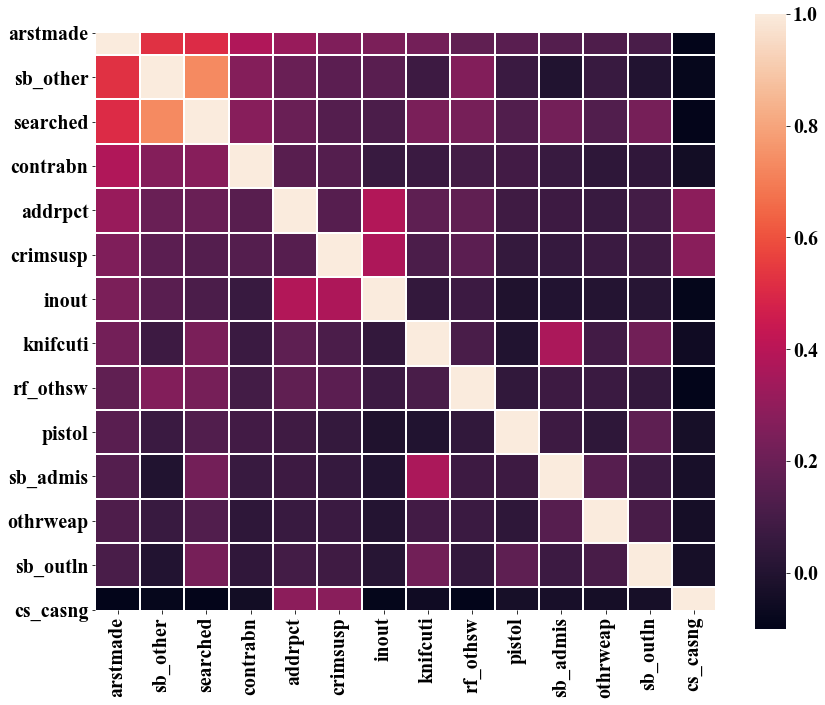

In [55]:
import seaborn as sns


pdf = PdfPages(r'.\figures\Figure_hm_1416.pdf')
figure, ax = plt.subplots(figsize=(12,12*0.8))
figure.tight_layout()
sns.heatmap(corrs[chosen_fhm].loc[chosen_fhm], vmin=-0.1, vmax=1, linewidths=1, square=True, ax=ax)
#ax.set_yticklabels(labels=corrs.index, rotation=0)
#ax.set_xticklabels(labels=corrs.columns, rotation=90)
pdf.savefig(figure,bbox_inches='tight',dpi=figure.dpi,pad_inches=0.0)
pdf.close()

# feature engineering

## one-hot encoding

In [25]:
drops = [ 'crimsusp','addrpct', 'sex', 'race',
        'haircolr', 'eyecolor', 'build', 'typeofid']
for cat in drops[:]:
    temp = pd.get_dummies(dataClean[cat], prefix=cat)
    dataClean = dataClean.drop(cat, 1)
    dataClean = pd.concat([dataClean, temp], axis=1)
    del temp

## polynomial 

In [26]:
#timestop
timestop = dataClean.loc[:, ['timestop']]/60
timestop['timestop2'] = timestop**2
timestop['timestop3'] = timestop.iloc[:, 0]**2
dataClean = dataClean.drop('timestop', 1)
dataClean = pd.concat([dataClean, timestop], axis=1)
del timestop

cpi_poly = dataClean.loc[:, ['CPI']]
cpi_poly['CPI2'] = cpi_poly**2

sp500_poly = dataClean.loc[:, ['SP500']] 
sp500_poly['sp2'] = sp500_poly**2

dataClean = dataClean.drop(['CPI', 'SP500'], 1)
dataClean = pd.concat([dataClean, cpi_poly, sp500_poly], axis=1)

del cpi_poly, sp500_poly

## merge columns
#### after one-hot, there are few data in some categories, merge them with other

In [27]:
chosen = dataClean.sum(0).loc[dataClean.sum(0)<10].index
data_crim = dataClean.loc[:, chosen[2:-3]].sum(1)
dataClean['crimsusp_other'] = data_crim
dataClean = dataClean.drop(chosen[2:-3], 1)
                           
dataClean['eyecolor_Z'] = dataClean['eyecolor_Z'] + dataClean['eyecolor_MA'] + dataClean['eyecolor_P']
dataClean['haircolr_ZZ'] = dataClean['haircolr_ZZ'] + dataClean['haircolr_SN']                          

dataClean = dataClean.drop(chosen[-3:], 1)
chosen

Index(['riflshot', 'asltweap', 'crimsusp_1', 'crimsusp_2', 'crimsusp_5',
       'crimsusp_7', 'crimsusp_15', 'crimsusp_19', 'crimsusp_25',
       'crimsusp_26', 'crimsusp_27', 'crimsusp_40', 'crimsusp_41',
       'crimsusp_42', 'crimsusp_44', 'crimsusp_45', 'crimsusp_46',
       'crimsusp_47', 'crimsusp_48', 'crimsusp_51', 'crimsusp_52',
       'crimsusp_54', 'crimsusp_55', 'crimsusp_56', 'crimsusp_58',
       'haircolr_SN', 'eyecolor_MA', 'eyecolor_P'],
      dtype='object')

In [28]:
print (np.shape(dataClean))
dataClean.describe()

(65343, 209)


,arstmade,inout,offunif,frisked,searched,contrabn,pistol,riflshot,asltweap,knifcuti,othrweap,age,weight,ht,year,month,radio,ac_rept,ac_inves,rf_vcrim,rf_othsw,ac_proxm,rf_attir,cs_objcs,cs_descr,cs_casng,cs_lkout,rf_vcact,cs_cloth,cs_drgtr,ac_evasv,ac_assoc,cs_furtv,rf_rfcmp,ac_cgdir,rf_verbl,cs_vcrim,cs_bulge,cs_other,ac_incid,ac_time,rf_knowl,ac_stsnd,ac_other,sb_hdobj,sb_outln,sb_admis,sb_other,explnstp,othpers,sumissue,perobs,perstop,CPI_F,CPI_H,CPI_C,CPI_T,CPI_M,crimsusp_3,crimsusp_4,crimsusp_6,crimsusp_8,crimsusp_9,crimsusp_10,crimsusp_11,crimsusp_12,crimsusp_13,crimsusp_14,crimsusp_16,crimsusp_17,crimsusp_18,crimsusp_20,crimsusp_21,crimsusp_22,crimsusp_23,crimsusp_24,crimsusp_28,crimsusp_29,crimsusp_31,crimsusp_32,crimsusp_33,crimsusp_34,crimsusp_36,crimsusp_37,crimsusp_38,crimsusp_39,crimsusp_43,crimsusp_49,crimsusp_50,crimsusp_53,addrpct_1,addrpct_5,addrpct_6,addrpct_7,addrpct_9,addrpct_10,addrpct_13,addrpct_14,addrpct_17,addrpct_18,addrpct_19,addrpct_20,addrpct_22,addrpct_23,addrpct_24,addrpct_25,addrpct_26,addrpct_28,addrpct_30,addrpct_32,addrpct_33,addrpct_34,addrpct_40,addrpct_41,addrpct_42,addrpct_43,addrpct_44,addrpct_45,addrpct_46,addrpct_47,addrpct_48,addrpct_49,addrpct_50,addrpct_52,addrpct_60,addrpct_61,addrpct_62,addrpct_63,addrpct_66,addrpct_67,addrpct_68,addrpct_69,addrpct_70,addrpct_71,addrpct_72,addrpct_73,addrpct_75,addrpct_76,addrpct_77,addrpct_78,addrpct_79,addrpct_81,addrpct_83,addrpct_84,addrpct_88,addrpct_90,addrpct_94,addrpct_100,addrpct_101,addrpct_102,addrpct_103,addrpct_104,addrpct_105,addrpct_106,addrpct_107,addrpct_108,addrpct_109,addrpct_110,addrpct_111,addrpct_112,addrpct_113,addrpct_114,addrpct_115,addrpct_120,addrpct_121,addrpct_122,addrpct_123,sex_F,sex_M,race_A,race_B,race_I,race_P,race_Q,race_W,race_Z,haircolr_BA,haircolr_BK,haircolr_BL,haircolr_BR,haircolr_DY,haircolr_GY,haircolr_RA,haircolr_SP,haircolr_ZZ,eyecolor_BK,eyecolor_BL,eyecolor_BR,eyecolor_DF,eyecolor_GR,eyecolor_GY,eyecolor_HA,eyecolor_Z,build_H,build_M,build_T,build_U,typeofid_O,typeofid_P,typeofid_R,typeofid_V,timestop,timestop2,timestop3,CPI,CPI2,SP500,sp2,crimsusp_other
count,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.00000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.000000,65343.0

# read feature-label data direcly

In [41]:
#dataClean.to_csv(r".\DTT.csv")


# train test split
## never use test set for model selction

In [29]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

## balance data set

In [30]:
data0 = dataClean.loc[dataClean['arstmade']==0]
data1 = dataClean.loc[dataClean['arstmade']==1]
print (len(data0), len(data1))

54230 11113


## use stratified split to avoid structure change in features

In [32]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.75, random_state=0)
data0Y = data0[['arstmade']]
data0X = data0.drop('arstmade', 1)

for idx1, idx2 in sss.split(data0X, data0Y):
    print (len(idx1), len(idx2))

data0_used = data0.iloc[idx1, :]

#check whether structure change
abs(data0.describe().loc[['mean', 'std'], :] - data0_used.describe().loc[['mean', 'std'], :])

13557 40673


,arstmade,inout,offunif,frisked,searched,contrabn,pistol,riflshot,asltweap,knifcuti,othrweap,age,weight,ht,year,month,radio,ac_rept,ac_inves,rf_vcrim,rf_othsw,ac_proxm,rf_attir,cs_objcs,cs_descr,cs_casng,cs_lkout,rf_vcact,cs_cloth,cs_drgtr,ac_evasv,ac_assoc,cs_furtv,rf_rfcmp,ac_cgdir,rf_verbl,cs_vcrim,cs_bulge,cs_other,ac_incid,ac_time,rf_knowl,ac_stsnd,ac_other,sb_hdobj,sb_outln,sb_admis,sb_other,explnstp,othpers,sumissue,perobs,perstop,CPI_F,CPI_H,CPI_C,CPI_T,CPI_M,crimsusp_3,crimsusp_4,crimsusp_6,crimsusp_8,crimsusp_9,crimsusp_10,crimsusp_11,crimsusp_12,crimsusp_13,crimsusp_14,crimsusp_16,crimsusp_17,crimsusp_18,crimsusp_20,crimsusp_21,crimsusp_22,crimsusp_23,crimsusp_24,crimsusp_28,crimsusp_29,crimsusp_31,crimsusp_32,crimsusp_33,crimsusp_34,crimsusp_36,crimsusp_37,crimsusp_38,crimsusp_39,crimsusp_43,crimsusp_49,crimsusp_50,crimsusp_53,addrpct_1,addrpct_5,addrpct_6,addrpct_7,addrpct_9,addrpct_10,addrpct_13,addrpct_14,addrpct_17,addrpct_18,addrpct_19,addrpct_20,addrpct_22,addrpct_23,addrpct_24,addrpct_25,addrpct_26,addrpct_28,addrpct_30,addrpct_32,addrpct_33,addrpct_34,addrpct_40,addrpct_41,addrpct_42,addrpct_43,addrpct_44,addrpct_45,addrpct_46,addrpct_47,addrpct_48,addrpct_49,addrpct_50,addrpct_52,addrpct_60,addrpct_61,addrpct_62,addrpct_63,addrpct_66,addrpct_67,addrpct_68,addrpct_69,addrpct_70,addrpct_71,addrpct_72,addrpct_73,addrpct_75,addrpct_76,addrpct_77,addrpct_78,addrpct_79,addrpct_81,addrpct_83,addrpct_84,addrpct_88,addrpct_90,addrpct_94,addrpct_100,addrpct_101,addrpct_102,addrpct_103,addrpct_104,addrpct_105,addrpct_106,addrpct_107,addrpct_108,addrpct_109,addrpct_110,addrpct_111,addrpct_112,addrpct_113,addrpct_114,addrpct_115,addrpct_120,addrpct_121,addrpct_122,addrpct_123,sex_F,sex_M,race_A,race_B,race_I,race_P,race_Q,race_W,race_Z,haircolr_BA,haircolr_BK,haircolr_BL,haircolr_BR,haircolr_DY,haircolr_GY,haircolr_RA,haircolr_SP,haircolr_ZZ,eyecolor_BK,eyecolor_BL,eyecolor_BR,eyecolor_DF,eyecolor_GR,eyecolor_GY,eyecolor_HA,eyecolor_Z,build_H,build_M,build_T,build_U,typeofid_O,typeofid_P,typeofid_R,typeofid_V,timestop,timestop2,timestop3,CPI,CPI2,SP500,sp2,crimsusp_other
mean,0.0,0.003240,0.005958,0.000290,0.000310,0.000829,0.000258,0.000037,0.0,0.000055,0.000535,0.086282,0.019842,0.016019,0.002827,0.029204,0.004091,0.002499,0.005011,0.002922,0.003158,0.000689,0.002358,0.000681,0.004328,0.004361,0.002374,0.001829,0.002030,0.001731,0.001874,0.002763,0.003731,0.001498,0.002998,0.000700,0.000299,0.001312,0.002164,0.000423,0.003214,0.000219,0.000259,0.002585,0.002137,0.000701,0.000018,0.000628,0.000092,0.001298,0.001052,0.011013,0.027710,0.012410,0.031113,0.004538,0.021656,0.065201,0.000645,0.002672,0.000111,0.000442,0.000203,0.000019,0.000461,0.007657,0.001162,0.000350,0.000974,0.000018,0.000055,0.000018,0.000038,0.000019,0.000074,5.440725e-09,0.000294,0.000111,3.536471e-08,0.002594,0.000111,0.000422,0.000111,0.000295,0.000240,0.000662,0.000018,0.000129,0.001493,0.000111,0.000572,0.000461,0.000184,0.000037,0.000074,0.000387,0.000222,0.001623,0.000037,0.000129,0.000148,0.000480,0.000203,0.000388,0.000129,0.000147,0.000719,0.000056,0.000535,0.000922,0.000775,0.000461,0.000405,0.000536,0.000682,0.000756,0.001458,0.000922,0.000313,0.000037,0.000351,0.001216,0.000756,0.000903,6.338445e-07,0.000295,0.001162,0.000793,0.000073,0.002212,0.000019,0.00048,0.000111,0.000368,0.000369,0.000277,0.001015,0.000572,0.000516,0.000037,0.000536,0.000239,0.000941,0.001550,0.000369,0.000037,0.000424,0.000904,0.000462,0.000683,0.000701,0.000166,0.001529,0.000869,0.000296,0.000313,0.001419,0.000258,0.001365,0.001438,0.000073,0.000589,0.000184,0.000884,0.001326,0.001310,0.000442,0.000403,0.000403,0.001750,0.001013,0.000608,0.000256,0.004839,0.001913,0.000701,0.000111,0.004084,0.001365,0.004897,0.000184,0.000534,0.000258,0.000055,0.000147,0.003114,0.000553,0.002873,0.000074,0.000314,0.000018,0.000314,0.000258,0.000796,0.000775,0.001129,0.000442,0.000977,0.003949,0.000091,0.002881,0.003150,0.030000,0.030000,0.015087,7.193101,0.513435,2067.182308,0.0

## data used to train, validate, test

In [186]:
data_used = pd.concat([data0_used, data1], axis=0)

## read the data_used directly

In [187]:
#data_used.to_csv(r".\data_used.csv")
len(data_used)

24670

## standardize the train_all, fit test

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

def CV(data, clf, nfold=5):
    X = data.drop(['arstmade'], 1)
    y = data['arstmade']    
    
    #store train, test scores
    scorings = ['recall', 'precision', 'accuracy', 'f1', 'roc_auc']
    keys = [t+'_'+sc for sc in scorings for t in ['train', 'test']]
    scores = {k: np.zeros(nfold) for k in keys}
    
    #store test details
    dtls = ['coef', 'interc', 'label', 'pred', 'pred_prob']
    details = {k:[] for k in dtls}
    
    #stratified Kfold, K=5 default
    skf = StratifiedKFold(n_splits=nfold, random_state=0, shuffle=True)
    for i, (tr_idx, te_idx) in enumerate(skf.split(X, y)):
        print (i, len(tr_idx), len(te_idx))
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        details['label'].append(y_te)
        
        #stdize the train set
        Xtr_sc = X_tr.loc[:, X_tr.max(0) > 1]
        scaler = StandardScaler().fit(Xtr_sc)
        Xtr_ = scaler.transform(Xtr_sc)
        Xtr_sc = pd.DataFrame(data=Xtr_, index=Xtr_sc.index, columns=Xtr_sc.columns)
        X_tr.loc[:, X_tr.max(0) > 1] = Xtr_sc
        
        #fit the model
        clf.fit(X_tr, y_tr)
        try:
            details['coef'].append(clf.coef_)
            details['interc'].append(clf.intercept_)
        except:
            print ("no coef, intercept in nonlinear kernel")
        
        #get train score
        acc = clf.score(X_tr, y_tr)
        scores['train_accuracy'][i] = acc
        
        y_tr_pred = clf.predict(X_tr)
        y_tr_pred_prob = clf.predict_proba(X_tr)
        
        rec = recall_score(y_tr, y_tr_pred)
        scores['train_recall'][i] = rec
        
        pre = precision_score(y_tr, y_tr_pred)
        scores['train_precision'][i] = pre
        
        f1 = f1_score(y_tr, y_tr_pred)
        scores['train_f1'][i] = f1
        
        auc = roc_auc_score(y_tr, y_tr_pred_prob[:, 1])
        scores['train_roc_auc'][i] = auc
        
        #pred the test
        Xte_sc = X_te.loc[:, X_tr.max(0) > 1]
        Xte_ = scaler.transform(Xte_sc)
        Xte_sc = pd.DataFrame(data=Xte_, index=Xte_sc.index, columns=Xte_sc.columns)
        X_te.loc[:, X_te.max(0) > 1] = Xte_sc
        
        y_te_pred = clf.predict(X_te)
        y_te_pred_prob = clf.predict_proba(X_te)
        
        details['pred'].append(y_te_pred)
        details['pred_prob'].append(y_te_pred_prob)
        
        #get test score
        acc = clf.score(X_te, y_te)
        scores['test_accuracy'][i] = acc
        
        y_te_pred = clf.predict(X_te)
        y_te_pred_prob = clf.predict_proba(X_te)
        
        rec = recall_score(y_te, y_te_pred)
        scores['test_recall'][i] = rec
        
        pre = precision_score(y_te, y_te_pred)
        scores['test_precision'][i] = pre
        
        f1 = f1_score(y_te, y_te_pred)
        scores['test_f1'][i] = f1
        
        auc = roc_auc_score(y_te, y_te_pred_prob[:, 1])
        scores['test_roc_auc'][i] = auc
        
    return details, scores, pd.DataFrame(scores)    

## no k folds to observe fairness

In [207]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix

def splitData(data):
    X = data.drop(['arstmade'], 1)
    y = data['arstmade']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    print (np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test))
    return X_train, X_test, y_train, y_test

def trainModel(Xtr, ytr, clf):
    Xtr_sc = Xtr.loc[:, Xtr.max(0) > 1]
    scaler = StandardScaler().fit(Xtr_sc)
    Xtr_ = scaler.transform(Xtr_sc)
    Xtr_sc = pd.DataFrame(data=Xtr_, index=Xtr_sc.index, columns=Xtr_sc.columns)
    Xtr.loc[:, Xtr.max(0) > 1] = Xtr_sc
    #print (Xtr.mean())
    
    clf.fit(Xtr, ytr)
    print ("train score = %.5f" % (clf.score(Xtr, ytr)))
    return scaler, clf

def fairness_on_test(Xte, yte, scaler, clf):
    print (clf.score(Xte, yte))
    Xte_sc = Xte.loc[:, Xte.max(0) > 1]
    Xte_ = scaler.transform(Xte_sc)
    Xte_sc = pd.DataFrame(data=Xte_, index=Xte_sc.index, columns=Xte_sc.columns)
    Xte.loc[:, Xte.max(0) > 1] = Xte_sc
    #print (Xte.mean())
    
    y_pred = clf.predict(Xte)
    #print (clf.score(Xte, yte))
    Xte['y_true'] = yte
    Xte['y_pred'] = y_pred
    return Xte

def get_fair_coef(X_train, clf):
    fair_col = [c for c in X_train.columns if c.startswith('race') or c.startswith('sex')]
    fair_coef = pd.DataFrame(data=clf.coef_[0], index=X_train.columns).loc[fair_col]
    return fair_coef

def FPR(pred, X_train):
    fair_col = [c for c in X_train.columns if c.startswith('race') or c.startswith('sex')]
    pred_fair = pred.loc[:, fair_col+['y_true', 'y_pred']]
    
    fprs = []
    tprs = []
    for col in fair_col[:]:
        data = pred_fair.loc[:, [col, 'y_true', 'y_pred']]
        data = data.loc[data[col]==1]
        tn, fp, fn, tp = confusion_matrix(data['y_true'], data['y_pred']).ravel()
        #print (tn, fp, fn, tp)
        fpr = fp/(fp+tn)
        tpr = tp/(tp+fn)
        fprs.append(fpr)
        tprs.append(tpr)
    
    return pd.DataFrame(data=fprs, index=fair_col), pd.DataFrame(data=tprs, index=fair_col)         

A	ASIAN/PACIFIC ISLANDER
B	BLACK
I	AMERICAN INDIAN/ALASKAN NATIVE
P	BLACK-HISPANIC
Q	WHITE-HISPANIC
W	WHITE
X	UNKNOWN
Z	OTHER

## use unblanced data

In [144]:
clf = LogisticRegression(fit_intercept=True,
                         penalty='none', # no regularization, l1, l2, elasticnet
                         random_state=0,
                         solver='lbfgs',
                         multi_class='ovr',
                         class_weight='none',
                         max_iter=1000,
                        )
details, scores, perf = CV(dataClean, clf)
clfs['logi_nr'] = details
print (perf.mean())
perf

0 52274 13069
1 52274 13069
2 52274 13069
3 52275 13068
4 52275 13068
train_recall       0.629083
test_recall        0.624494
train_precision    0.820929
test_precision     0.817072
train_accuracy     0.913579
test_accuracy      0.912355
train_f1           0.712314
test_f1            0.707908
train_roc_auc      0.915751
test_roc_auc       0.912105
dtype: float64


,train_recall,test_recall,train_precision,test_precision,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc
0,0.629921,0.626181,0.820152,0.817381,0.913571,0.912618,0.712559,0.709119,0.915276,0.912532
1,0.628909,0.623482,0.822569,0.818182,0.913819,0.912388,0.712820,0.707684,0.915209,0.915127
2,0.628121,0.618983,0.822628,0.821983,0.913724,0.912388,0.712336,0.706184,0.915520,0.912319
3,0.629513,0.626913,0.819473,0.814144,0.913400,0.912228,0.712041,0.708365,0.917458,0.905123
4,0.628951,0.626913,0.819821,0.813668,0.913381,0.912152,0.711813,0.708185,0.915294,0.915423


In [208]:
clf = LogisticRegression(fit_intercept=True,
                         penalty='none', # no regularization, l1, l2, elasticnet
                         random_state=0,
                         solver='lbfgs',
                         multi_class='ovr',
                         class_weight='none',
                         max_iter=1000,
                        )
X_train, X_test, y_train, y_test = splitData(dataClean)
scaler, clf = trainModel(X_train, y_train, clf)
X = fairness_on_test(X_test, y_test, scaler, clf)
fair_coef = get_fair_coef(X_train, clf)
fpr_df, tpr_df = FPR(X, X_train)
fair_coef, fpr_df, tpr_df

(45740, 208) (45740,) (19603, 208) (19603,)
train score = 0.91454
0.829515890424935


(               0
 sex_F  -0.148778
 sex_M  -0.487780
 race_A -0.137379
 race_B -0.041836
 race_I -0.448264
 race_P  0.114376
 race_Q  0.060977
 race_W -0.273369
 race_Z  0.088938,                0
 sex_F   0.034700
 sex_M   0.027237
 race_A  0.013963
 race_B  0.026062
 race_I  0.014706
 race_P  0.025907
 race_Q  0.033601
 race_W  0.033368
 race_Z  0.012739,                0
 sex_F   0.675958
 sex_M   0.604255
 race_A  0.581818
 race_B  0.593310
 race_I  0.375000
 race_P  0.658088
 race_Q  0.649611
 race_W  0.557325
 race_Z  0.685714)

## without any reg

In [35]:
clfs = dict()

In [149]:
clf = LogisticRegression(fit_intercept=True,
                         penalty='none', # no regularization, l1, l2, elasticnet
                         random_state=0,
                         solver='lbfgs',
                         multi_class='ovr',
                         class_weight='none',
                         max_iter=1000,
                        )
details, scores, perf = CV(data_used, clf)
clfs['logi_nr'] = details
print (perf.mean())
perf

0 19735 4935
1 19735 4935
2 19736 4934
3 19737 4933
4 19737 4933
train_recall       0.787096
test_recall        0.781876
train_precision    0.877419
test_precision     0.872130
train_accuracy     0.854560
test_accuracy      0.850101
train_f1           0.829805
test_f1            0.824510
train_roc_auc      0.919815
test_roc_auc       0.914600
dtype: float64


,train_recall,test_recall,train_precision,test_precision,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc
0,0.786052,0.789024,0.876238,0.875686,0.853610,0.854509,0.828698,0.830099,0.919478,0.917437
1,0.788751,0.780027,0.878147,0.865269,0.855536,0.846201,0.831052,0.820440,0.919855,0.913984
2,0.784139,0.783626,0.877628,0.874937,0.853516,0.852047,0.828254,0.826768,0.918777,0.917816
3,0.785176,0.792529,0.877010,0.872646,0.853625,0.854450,0.828556,0.830660,0.920047,0.913472
4,0.791362,0.764176,0.878073,0.872111,0.856513,0.843300,0.832466,0.814584,0.920915,0.910292


In [209]:
clf = LogisticRegression(fit_intercept=True,
                         penalty='none', # no regularization, l1, l2, elasticnet
                         random_state=0,
                         solver='lbfgs',
                         multi_class='ovr',
                         class_weight='none',
                         max_iter=1000,
                        )
X_train, X_test, y_train, y_test = splitData(data_used)
scaler, clf = trainModel(X_train, y_train, clf)
X = fairness_on_test(X_test, y_test, scaler, clf)
fair_coef = get_fair_coef(X_train, clf)
fpr_df, tpr_df = FPR(X, X_train)
fair_coef, fpr_df, tpr_df

(17269, 208) (17269,) (7401, 208) (7401,)
train score = 0.85431
0.5549250101337657


(               0
 sex_F   0.140808
 sex_M  -0.094797
 race_A -0.086671
 race_B  0.014945
 race_I -0.005821
 race_P  0.187162
 race_Q  0.099414
 race_W -0.213482
 race_Z  0.050464,                0
 sex_F   0.129921
 sex_M   0.097067
 race_A  0.032110
 race_B  0.099453
 race_I  0.200000
 race_P  0.118774
 race_Q  0.112568
 race_W  0.085595
 race_Z  0.162162,                0
 sex_F   0.819113
 sex_M   0.795068
 race_A  0.726496
 race_B  0.787416
 race_I  0.857143
 race_P  0.832143
 race_Q  0.818907
 race_W  0.761468
 race_Z  0.937500)

## with l1 reg

In [154]:
clf = LogisticRegression(fit_intercept=True,
                         penalty='l1', # no regularization, l1, l2, elasticnet
                         random_state=0,
                         solver='saga',
                         multi_class='ovr',
                         class_weight='none',
                         max_iter=1000,
                        )
details, scores, perf = CV(data_used, clf)
clfs['logi_l2'] = clf
perf

0 19735 4935
1 19735 4935
2 19736 4934
3 19737 4933
4 19737 4933


,train_recall,test_recall,train_precision,test_precision,train_accuracy,test_accuracy,train_f1,test_f1,train_roc_auc,test_roc_auc
0,0.782340,0.787224,0.877160,0.876314,0.852597,0.854103,0.827041,0.829384,0.918995,0.918014
1,0.785939,0.778228,0.880418,0.868038,0.855485,0.846809,0.830500,0.820683,0.919570,0.913654
2,0.780652,0.778677,0.878481,0.876012,0.852554,0.850628,0.826683,0.824482,0.918308,0.918937
3,0.781577,0.793429,0.876514,0.875372,0.852004,0.856071,0.826327,0.832389,0.919556,0.914758
4,0.786638,0.761026,0.877101,0.875712,0.854233,0.843706,0.829410,0.814351,0.920460,0.910362


In [155]:
perf.mean()

train_recall       0.783429
test_recall        0.779717
train_precision    0.877935
test_precision     0.874290
train_accuracy     0.853375
test_accuracy      0.850263
train_f1           0.827992
test_f1            0.824258
train_roc_auc      0.919378
test_roc_auc       0.915145
dtype: float64

In [210]:
clf = LogisticRegression(fit_intercept=True,
                         penalty='l1', # no regularization, l1, l2, elasticnet
                         random_state=0,
                         solver='saga',
                         multi_class='ovr',
                         class_weight='none',
                         max_iter=1000,
                         
                        )
X_train, X_test, y_train, y_test = splitData(data_used)
scaler, clf = trainModel(X_train, y_train, clf)
X = fairness_on_test(X_test, y_test, scaler, clf)
fair_coef = get_fair_coef(X_train, clf)
fpr_df, tpr_df = FPR(X, X_train)
fair_coef, fpr_df, tpr_df

(17269, 208) (17269,) (7401, 208) (7401,)
train score = 0.85309
0.5549250101337657


(               0
 sex_F   0.001923
 sex_M  -0.232384
 race_A -0.106998
 race_B -0.026450
 race_I  0.000000
 race_P  0.141030
 race_Q  0.067481
 race_W -0.214459
 race_Z  0.000000,                0
 sex_F   0.137795
 sex_M   0.093174
 race_A  0.027523
 race_B  0.097172
 race_I  0.200000
 race_P  0.118774
 race_Q  0.109290
 race_W  0.077244
 race_Z  0.162162,                0
 sex_F   0.822526
 sex_M   0.791403
 race_A  0.709402
 race_B  0.782529
 race_I  0.857143
 race_P  0.832143
 race_Q  0.816629
 race_W  0.767584
 race_Z  0.937500)

In [211]:
all_coef = pd.DataFrame(data=clf.coef_[0], index=X_train.columns)
all_coef.sort_values(by=0)

,0
sumissue,-3.144655
addrpct_121,-1.423483
crimsusp_12,-1.168010
typeofid_R,-1.101323
addrpct_52,-1.075967
addrpct_120,-0.786389
radio,-0.717327
addrpct_67,-0.683681
addrpct_50,-0.680272
cs_cloth,-0.560391


In [220]:
iii = [i for i in all_coef.index if i.startswith('CPI') or i.startswith('SP') or i.startswith('sp')]
all_coef.loc[iii]

,0
CPI_F,-0.030018
CPI_H,0.000000
CPI_C,-0.040998
CPI_T,-0.029361
CPI_M,0.182574
CPI,0.000000
CPI2,0.000000
SP500,-0.045306
sp2,-0.065816


In [221]:
93.5*np.exp(0.05*0.5)

95.8669637690341

In [225]:
d1 = (np.log(93.5/90)+(0.05+0.04/2)*0.5)/(0.2*np.sqrt(1/2))
d1

0.5172610976918178

In [224]:
d2 = (np.log(93.5/90)+(0.05+0.04/2)*0.5)/(0.2*np.sqrt(1/2)) - 0.2*np.sqrt(1/2)
d2

0.37583974145450827

In [227]:
93.5*0.6950-90*np.exp(-0.025)*0.6443

8.427204131213074

In [229]:
8.4272+90*np.exp(-0.025)-93.5

2.705092082549939

In [231]:
(0.05/0.2-0.1)*np.sqrt(0.5)

0.10606601717798213

In [233]:
0.5398*np.exp(-0.025)

0.5264722905128939

In [235]:
5 - 5.25*np.exp(-0.05)

0.006045521371251361

In [238]:
(5.6*0.6 + 0*0.4)/1.08

3.1111111111111107

In [240]:
(19.185*0.6+3.11*0.4)/1.08

11.810185185185183

In [243]:
((100.8*0.6)**2+2*0.6*0.4*75.6**2+0.4**2*56.7**2)/1.08**2

5928.999999999999

In [250]:
(8.25+800-800*np.exp(-0.3))*0.1125

24.25448513864539

In [251]:
75.75*np.exp(.3)-100

2.2518046738822477